# intersect microexons by human-specific gaps, insertions, substitutions

input 

- MSA 30-way all human gaps/insertions/subs bed
    - formatted from ./2_format_subs_indels.ipynb
    
- microexon bed 
    - formatted from ./0_microexon-to-bed.ipynb
    
method
   - pybedtool intersection: microexon x hu-specific subs/gaps/ins
       - write microexon info, write hu-specific subs/gaps/ins info
       
   - write intersection file
   
   - inspect microexon overlapping variants
   
   - inspect microexon intron/exon variants
   
   
return
   - intersection file

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pbt
import seaborn as sns

import config_readwrite as crw

config_tag = "config.ini"
config, configfile_name = crw.read_config(os.path.join(os.getcwd(), config_tag))

PATH = config["hu-specific"]["path"]
ALL = config["hu-specific"]["file"]

ME_PUT = config["microexon"]["bed"]
ME_GEN = config["GENCODE"]["microexon"]
ME_VDB = config["VASTDB"]["microexon"]
ME_THREEDF=config["microexon"]["threedb"] # write. Combo of gencode, vast, and de novo

ME_NS = config["microexon"]["neuronal_strict"]
ME_NR = config["microexon"]["neuronal_relaxed"]

RE = config["hu_x_me"]["results"]

# combine VDB, putative, and GENCODE microexons. 

In [58]:
files=[ME_PUT, ME_GEN, ME_VDB]

collection = {}

for file in files:
    df = pd.read_csv(file, sep='\t')
    
    if "vast" in file:
        df.columns = ["#chr", "start", "end", "geneName", 'event', "id", "len", "label"]
        df["dataset"] = 'VastDB'
        
    elif "gencode" in file:
        df["dataset"] = 'Gencode.v42'
    
    else:
        df["dataset"] = 'de-novo'
        
    # add id, len columns
    df["id"] = df['#chr'] +":" +df["start"].map(str) + "-"+ df["end"].map(str)
    df["len"] = df["end"]-df["start"]

    # drop gene_Id column
    if "gene_Id" in list(df):
        df = df.drop(columns =["gene_Id"])
        
    collection[file] = df


out = pd.concat(collection.values())
out.to_csv(ME_THREEDF, sep='\t', index=False)

In [59]:
print(out.shape)
out.head()

(28635, 9)


,#chr,start,end,geneName,label,event,dataset,id,len
0,chr1,65353105,65353109,DNAJC6,microexon,putative_microexon_000715026,de-novo,chr1:65353105-65353109,4
1,chr6,109450989,109451014,MICAL1,microexon,putative_microexon_000716496,de-novo,chr6:109450989-109451014,25
2,chr10,37853628,37853645,ZNF248,microexon,putative_microexon_000716992,de-novo,chr10:37853628-37853645,17
3,chrX,85923678,85923681,CHM,microexon,putative_microexon_000769555,de-novo,chrX:85923678-85923681,3
4,chr11,13358220,13358225,ARNTL,microexon,putative_microexon_000771565,de-novo,chr11:13358220-13358225,5


In [60]:
out.loc[out.len>2].shape

(28635, 9)

In [61]:
c = out.groupby(["id"])["#chr"].count().reset_index()
c.loc[c["#chr"]>1]

,id,#chr
27,chr10:102861859-102862158,2
28,chr10:102862159-102862180,2
29,chr10:102862180-102862480,2
33,chr10:103105057-103105356,2
34,chr10:103105357-103105381,2
...,...,...
23957,chrX:75114620-75114632,2
23958,chrX:75114632-75114932,2
23962,chrX:75505520-75505819,2
23963,chrX:75505820-75505847,2


In [62]:
out.loc[out["id"]=="chrX:75114632-75114932"]

,#chr,start,end,geneName,label,event,dataset,id,len
11788,chrX,75114632,75114932,ABCB7,dsINT,ENSG00000131269.19,Gencode.v42,chrX:75114632-75114932,300
8895,chrX,75114632,75114932,ABCB7,dsINT,HsaEX0000367,VastDB,chrX:75114632-75114932,300


In [63]:
list(out)

['#chr', 'start', 'end', 'geneName', 'label', 'event', 'dataset', 'id', 'len']

In [64]:
len(out["id"].unique())

24145

In [65]:
print(len(out.loc[out["dataset"].str.contains("code"), "geneName"].unique()))
print(len(out.loc[out["dataset"].str.contains("Vast"), "geneName"].unique()))
print(len(out.loc[out["dataset"].str.contains("novo"), "geneName"].unique()))

3150
3171
1250


# human-specific mutation intersection

In [67]:
def intersectHuSp(me, name, config_item):
    out = f"/wynton/home/ahituv/fongsl/microexons/data/{name}_x_HUSP.bed"

    if os.path.exists(out) is False:

        # add out file to config

        crw.check_section(config, "hu_x_me")
        config["hu_x_me"][config_item]=out
        crw.write_config(config, configfile_name )

        print("running intersection of microexon x human-specific mutations")

        ## load bed objects 

        bed = pbt.BedTool(ALL)
        me = pbt.BedTool(me)

        ## intersect human-specific mutations with microexon

        intr = me.intersect(bed, output=out, wa=True, wb=True)

    else:
        print("already intersected!")
    return out

In [85]:
# intersect w/ hu specific
outsp = intersectHuSp(ME_THREEDF, "microexon_3db", "threedb")

already intersected!


## inspect microexons

In [86]:
# check column names

if "#chr" not in list(pd.read_csv(outsp, sep = '\t', nrows=2)):
    
    # if columns not named, name cols
    cols = ['#chr', 'start', 'end', 'geneName', 'label', 'event', 'dataset', 'id', 'len',
            "#chrMut", "startMut", "endMut", "mafNSpecies", 
            "mafStart", "mafLen","species", "mut", "mutLen", "id"]
    
    # open out file, drop duplicates
    df = pd.read_csv(outsp, sep='\t', header=None).drop_duplicates()
    
    # rename cols
    df.columns=cols

    # re-save outfile
    df.to_csv(outsp, sep='\t', index=False)

else:
    df = pd.read_csv(outsp, sep='\t').drop_duplicates()

df.head()

,#chr,start,end,geneName,label,event,dataset,id,len,#chrMut,startMut,endMut,mafNSpecies,mafStart,mafLen,species,mut,mutLen,id.1
0,chr22,35954273,35954283,RBFOX2,microexon,putative_microexon_000554424,de-novo,chr22:35954273-35954283,10,chr22,35954281,35954282,28,35954255,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35954281-35954282
1,chr18,55601917,55601921,TCF4,microexon,putative_microexon_000557225,de-novo,chr18:55601917-55601921,4,chr18,55601919,55601920,24,55601867,60,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr18:55601919-55601920
2,chr6,79203033,79203047,HMGN3,microexon,putative_microexon_001669128,de-novo,chr6:79203033-79203047,14,chr6,79203033,79203034,29,79202977,140,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr6:79203033-79203034
3,chr3,16511156,16511159,RFTN1,microexon,putative_microexon_000871665,de-novo,chr3:16511156-16511159,3,chr3,16511156,16511157,30,16511069,369,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr3:16511156-16511157
4,chr3,56448386,56448390,ERC2,microexon,putative_microexon_000718517,de-novo,chr3:56448386-56448390,4,chr3,56448387,56448388,29,56448252,244,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr3:56448387-56448388


In [89]:
df = df.drop(columns = ['dataset', "id.1", "mafStart"]).drop_duplicates()

KeyError: "['dataset', 'id.1', 'mafStart'] not found in axis"

In [90]:
print(df.shape)
df.head()

(26563, 16)


,#chr,start,end,geneName,label,event,id,len,#chrMut,startMut,endMut,mafNSpecies,mafLen,species,mut,mutLen
0,chr22,35954273,35954283,RBFOX2,microexon,putative_microexon_000554424,chr22:35954273-35954283,10,chr22,35954281,35954282,28,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
1,chr18,55601917,55601921,TCF4,microexon,putative_microexon_000557225,chr18:55601917-55601921,4,chr18,55601919,55601920,24,60,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
2,chr6,79203033,79203047,HMGN3,microexon,putative_microexon_001669128,chr6:79203033-79203047,14,chr6,79203033,79203034,29,140,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
3,chr3,16511156,16511159,RFTN1,microexon,putative_microexon_000871665,chr3:16511156-16511159,3,chr3,16511156,16511157,30,369,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
4,chr3,56448386,56448390,ERC2,microexon,putative_microexon_000718517,chr3:56448386-56448390,4,chr3,56448387,56448388,29,244,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1


# how many microexon overlaps are there?  

In [95]:
## keep only label and genomecoordinates
countdf = df[["label", 'id']].drop_duplicates()

In [96]:
countdf.groupby("label")["id"].count()

label
dsINT        6327
microexon     437
upINT        6424
Name: id, dtype: int64

## what kind of mutations overlap microexons? 

In [121]:
label_df = df[["label", 'id', "mut", "len"]].drop_duplicates()
label_mut = label_df.groupby(["label", "mut"])["id"].count().reset_index()
label_mut

,label,mut,id
0,dsINT,DEL,593
1,dsINT,INS,471
2,dsINT,SUB,5263
3,microexon,DEL,15
4,microexon,INS,16
5,microexon,SUB,406
6,upINT,DEL,583
7,upINT,INS,464
8,upINT,SUB,5377


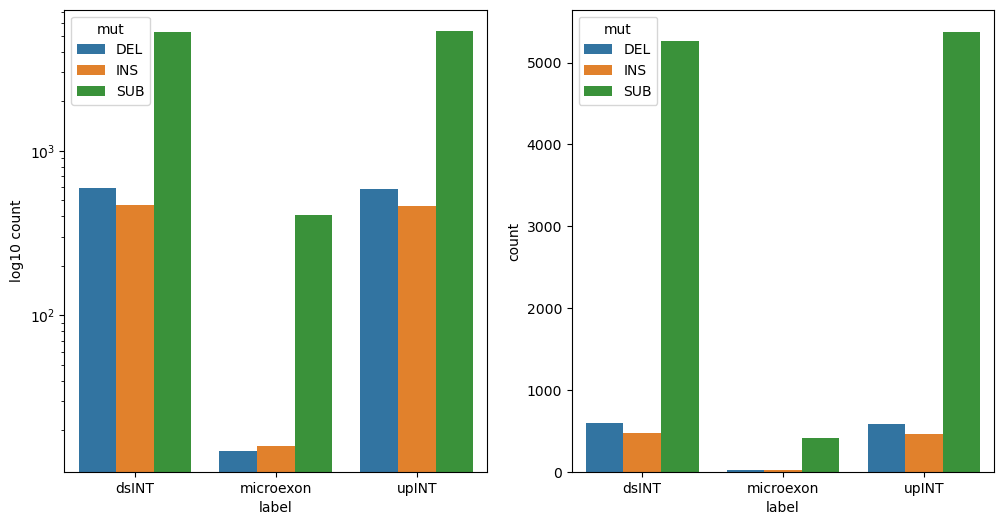

In [102]:
fig,(ax, ax2) = plt.subplots(ncols = 2, figsize = (12,6))
sns.barplot(data=label_mut, x ="label", hue="mut", y="id", ax=ax)
ax.set(yscale = 'log', 
      ylabel = "log10 count")
sns.barplot(data=label_mut, x ="label", hue="mut", y="id", ax=ax2)
ax2.set(ylabel = "count")

plt.savefig(os.path.join(RE, "meGen_x_huspec_counts.pdf"), bbox_inches="tight")

### how many unique genes are impacted by microexons?  

In [100]:
len(df.loc[(df["label"].str.contains("exon")), 'geneName'].unique())

416

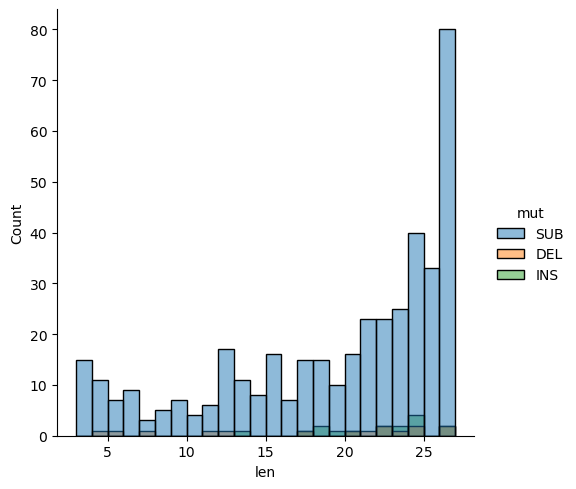

In [130]:

sns.displot(x="len", data=label_df.loc[df.label=="microexon"], bins=24, hue="mut", kind="hist")



In [24]:
len(df.len.unique())

24

### how many gene names have microexons + hu-specific substitutions?

In [25]:
len(df['geneName'].unique())

252

## inspect DELS

In [108]:
df.loc[(df["label"].str.contains('exon')) & (df["mut"]=="DEL")].sort_values(by="geneName")

,#chr,start,end,geneName,label,event,id,len,#chrMut,startMut,endMut,mafNSpecies,mafLen,species,mut,mutLen
12,chr9,40228343,40228365,ANKRD20A2,microexon,putative_microexon_001375454,chr9:40228343-40228365,22,chr9,40228343,40228344,16,273,"hg38,panPan2,gorGor5,nomLeu3,rheMac8,macFas5,m...",DEL,1
4277,chr13,114222497,114222518,CFAP97D2,microexon,ENSG00000283361.3,chr13:114222497-114222518,21,chr13,114222513,114222514,25,171,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,2
4315,chr16,89948790,89948814,DEF8,microexon,ENSG00000140995.17,chr16:89948790-89948814,24,chr16,89948793,89948794,10,11,"hg38,panTro5,gorGor5,ponAbe2,nomLeu3,rheMac8,m...",DEL,2
43,chr2,241684501,241684508,DTYMK,microexon,putative_microexon_001588188,chr2:241684501-241684508,7,chr2,241684505,241684506,20,280,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,8
4240,chr10,4497448,4497475,ENSG00000286687,microexon,ENSG00000286687.1,chr10:4497448-4497475,27,chr10,4497450,4497451,25,120,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,1
9,chr20,5571014,5571031,GPCPD1,microexon,putative_microexon_001380314,chr20:5571014-5571031,17,chr20,5571022,5571023,23,349,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,3
15895,chr2,149159220,149159231,LYPD6B,microexon,HsaEX1022493,chr2:149159220-149159231,11,chr2,149159226,149159227,28,189,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,5
36,chr17,12095462,12095466,MAP2K4,microexon,putative_microexon_000050732,chr17:12095462-12095466,4,chr17,12095465,12095466,30,428,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,4
20,chr4,77928045,77928067,MRPL1,microexon,putative_microexon_000104477,chr4:77928045-77928067,22,chr4,77928045,77928046,27,809,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,1
4352,chr2,152717992,152718012,PRPF40A,microexon,ENSG00000196504.21,chr2:152717992-152718012,20,chr2,152718011,152718012,30,145,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",DEL,8


## inspect INS 

In [109]:
df.loc[(df["label"].str.contains('exon'))& (df["mut"]=="INS")].sort_values(by="geneName")

,#chr,start,end,geneName,label,event,id,len,#chrMut,startMut,endMut,mafNSpecies,mafLen,species,mut,mutLen
4409,chr4,106316577,106316594,AIMP1,microexon,ENSG00000164022.18,chr4:106316577-106316594,17,chr4,106316579,106316580,26,756,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,1
4360,chr20,10902283,10902302,ENSG00000270792,microexon,ENSG00000270792.6,chr20:10902283-10902302,19,chr20,10902288,10902290,26,128,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,2
4391,chr3,128563315,128563339,ENSG00000286806,microexon,ENSG00000286806.1,chr3:128563315-128563339,24,chr3,128563338,128563339,20,127,"hg38,panTro5,panPan2,gorGor5,ponAbe2,rheMac8,m...",INS,1
4273,chr13,54572353,54572379,ENSG00000287460,microexon,ENSG00000287460.1,chr13:54572353-54572379,26,chr13,54572370,54572372,4,881,"hg38,panTro5,panPan2,gorGor5",INS,2
4274,chr13,54572356,54572379,ENSG00000287460,microexon,ENSG00000287460.1,chr13:54572356-54572379,23,chr13,54572370,54572372,4,881,"hg38,panTro5,panPan2,gorGor5",INS,2
4431,chr6,36391906,36391924,ETV7-AS1,microexon,ENSG00000224666.3,chr6:36391906-36391924,18,chr6,36391918,36391920,22,13,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,2
4432,chr6,36391906,36391924,ETV7-AS1,microexon,ENSG00000224666.3,chr6:36391906-36391924,18,chr6,36391920,36391921,27,37,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,1
4385,chr3,48695558,48695582,IP6K2,microexon,ENSG00000068745.15,chr3:48695558-48695582,24,chr3,48695563,48695564,28,162,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,1
15888,chr11,12259240,12259253,MICAL2,microexon,HsaEX1023604,chr11:12259240-12259253,13,chr11,12259242,12259243,25,219,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,1
4245,chr10,73126634,73126657,NUDT13,microexon,ENSG00000166321.14,chr10:73126634-73126657,23,chr10,73126635,73126636,30,540,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",INS,1


## inspect subs

In [110]:
df.loc[(df["label"].str.contains('exon'))& (df["mut"]=="SUB")].sort_values(by="geneName")

,#chr,start,end,geneName,label,event,id,len,#chrMut,startMut,endMut,mafNSpecies,mafLen,species,mut,mutLen
11,chr7,87681056,87681061,ABCB1,microexon,putative_microexon_000217610,chr7:87681056-87681061,5,chr7,87681057,87681058,6,1136,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3",SUB,1
15752,chr2,47948383,47948409,AC079807.4,microexon,HsaEX7001123,chr2:47948383-47948409,26,chr2,47948399,47948400,19,205,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
15882,chr14,75054817,75054828,ACYP1,microexon,HsaEX1002587,chr14:75054817-75054828,11,chr14,75054818,75054819,30,307,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
45,chr20,44632403,44632426,ADA,microexon,putative_microexon_001523986,chr20:44632403-44632426,23,chr20,44632409,44632410,23,265,"hg38,panTro5,panPan2,gorGor5,ponAbe2,rheMac8,m...",SUB,1
4465,chr8,39491997,39492008,ADAM3A,microexon,ENSG00000197475.11,chr8:39491997-39492008,11,chr8,39492006,39492007,23,235,"hg38,ponAbe2,nomLeu3,rheMac8,macFas5,macNem1,c...",SUB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15845,chr20,46436461,46436488,NaN,microexon,HsaEX1000713,chr20:46436461-46436488,27,chr20,46436475,46436476,25,112,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
15853,chr4,70071229,70071253,NaN,microexon,HsaEX1000007,chr4:70071229-70071253,24,chr4,70071229,70071230,24,64,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
15854,chr4,70073004,70073031,NaN,microexon,HsaEX1000008,chr4:70073004-70073031,27,chr4,70073024,70073025,23,46,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
15865,chrY,19594757,19594783,NaN,microexon,HsaEX1001023,chrY:19594757-19594783,26,chrY,19594757,19594758,10,78,"hg38,panTro5,nomLeu3,rheMac8,macFas5,chlSab2,r...",SUB,1


## there are 58 nans (some are microexons) that need gene annotations

In [113]:
len(df.loc[df['geneName'].astype(str)=="nan"])

58

# RBFOX2

In [117]:
df.loc[(df["geneName"]== "RBFOX2")]

,#chr,start,end,geneName,label,event,id,len,#chrMut,startMut,endMut,mafNSpecies,mafLen,species,mut,mutLen
0,chr22,35954273,35954283,RBFOX2,microexon,putative_microexon_000554424,chr22:35954273-35954283,10,chr22,35954281,35954282,28,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
63,chr22,35954283,35954583,RBFOX2,dsINT,putative_microexon_000554424,chr22:35954283-35954583,300,chr22,35954297,35954298,28,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
563,chr22,35958195,35958495,RBFOX2,dsINT,putative_microexon_000575566,chr22:35958195-35958495,300,chr22,35958465,35958466,29,171,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
2201,chr22,35953973,35954273,RBFOX2,upINT,putative_microexon_000554424,chr22:35953973-35954273,300,chr22,35953976,35953977,24,87,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
2202,chr22,35953973,35954273,RBFOX2,upINT,putative_microexon_000554424,chr22:35953973-35954273,300,chr22,35954138,35954139,28,340,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
7992,chr22,35839891,35840190,RBFOX2,upINT,ENSG00000100320.24,chr22:35839891-35840190,299,chr22,35840098,35840099,30,1194,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1
18334,chr22,35839891,35840190,RBFOX2,upINT,HsaEX1030808,chr22:35839891-35840190,299,chr22,35840098,35840099,30,1194,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1


In [115]:
# get RBFOX2 start and stop coordinates

df.loc[(df["geneName"]== "RBFOX2")]["start"].min(), df.loc[(df["geneName"]== "RBFOX2")]["end"].max()

(35839891, 35958495)

# neural strict, relaxed 

In [38]:
neural_sets = [(ME_NS, "neural_strict"),
               (ME_NR, "neural_relaxed")]

# inspect neural sets:

for neural_set, label in neural_sets:
    
    # open the neural gene dataset. 
    neural_genes = (pd.read_csv(neural_set, usecols = ["event", "geneName"]))
    
    # add dataset identifier column
    neural_genes[label]=1
    
    print(neural_genes.shape)
    
    # merge identifier 
    df = pd.merge(df, neural_genes, how="left")
    df[label]=df[label].fillna(0)

(292, 3)
(457, 3)


In [39]:
df.head()

,#chr,start,end,geneName,label,event,#chrMut,startMut,endMut,mafNSpecies,mafStart,mafLen,species,mut,mutLen,id,len,neural_strict,neural_relaxed
0,chr22,35954273,35954283,RBFOX2,microexon,putative_microexon_000554424,chr22,35954281,35954282,28,35954255,299,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr22:35954281-35954282,-10,0.0,0.0
1,chr18,55601917,55601921,TCF4,microexon,putative_microexon_000557225,chr18,55601919,55601920,24,55601867,60,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr18:55601919-55601920,-4,0.0,0.0
2,chr6,79203033,79203047,HMGN3,microexon,putative_microexon_001669128,chr6,79203033,79203034,29,79202977,140,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr6:79203033-79203034,-14,0.0,0.0
3,chr3,16511156,16511159,RFTN1,microexon,putative_microexon_000871665,chr3,16511156,16511157,30,16511069,369,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr3:16511156-16511157,-3,1.0,1.0
4,chr3,56448386,56448390,ERC2,microexon,putative_microexon_000718517,chr3,56448387,56448388,29,56448252,244,"hg38,panTro5,panPan2,gorGor5,ponAbe2,nomLeu3,r...",SUB,1,chr3:56448387-56448388,-4,0.0,1.0


In [40]:
# RBFOX genes in neural strict, location, mutation, and count of mutations
df.loc[df["geneName"].str.contains("RBFOX")].groupby(["geneName","neural_strict", "label", "mut"])["id"].count()

geneName  neural_strict  label      mut
RBFOX1    0.0            dsINT      DEL      82
                                    INS      99
                                    SUB    2395
                         upINT      DEL     119
                                    INS     191
                                    SUB    3692
          1.0            dsINT      INS       3
                                    SUB      25
                         upINT      DEL      14
                                    INS      27
                                    SUB     498
RBFOX2    0.0            dsINT      DEL      15
                                    INS       7
                                    SUB     157
                         microexon  SUB       1
                         upINT      DEL      43
                                    INS      37
                                    SUB     700
Name: id, dtype: int64

# conserved microexons (no human-specific mutations)

In [49]:
mutated_microexon_genes = df[["event", "geneName"]].drop_duplicates()
all_genes = (pd.read_csv(ME, sep='\t', usecols = ["event", "geneName"]))

In [55]:
print(len(set(all_genes["event"]).difference(set(mutated_microexon_genes["event"]))))
(set(all_genes["event"]).difference(set(mutated_microexon_genes["event"])))

29


{'putative_microexon_000104993',
 'putative_microexon_000130151',
 'putative_microexon_000151274',
 'putative_microexon_000168271',
 'putative_microexon_000252068',
 'putative_microexon_000341120',
 'putative_microexon_000345553',
 'putative_microexon_000471313',
 'putative_microexon_000475858',
 'putative_microexon_000571477',
 'putative_microexon_000695894',
 'putative_microexon_000734605',
 'putative_microexon_000739316',
 'putative_microexon_000752598',
 'putative_microexon_000831654',
 'putative_microexon_000859357',
 'putative_microexon_000989291',
 'putative_microexon_001292303',
 'putative_microexon_001320778',
 'putative_microexon_001472722',
 'putative_microexon_001513005',
 'putative_microexon_001661046',
 'putative_microexon_001673033',
 'putative_microexon_001731885',
 'putative_microexon_001767304',
 'putative_microexon_001828316',
 'putative_microexon_001887164',
 'putative_microexon_001887790',
 'putative_microexon_001887793'}

In [56]:
print(len(set(all_genes["geneName"]).difference(set(mutated_microexon_genes["geneName"]))))
(set(all_genes["geneName"]).difference(set(mutated_microexon_genes["geneName"])))

27


{'ACADSB',
 'ADGRA1',
 'ANKZF1',
 'ATP11C',
 'ATRNL1',
 'BCCIP',
 'CCDC186',
 'CFAP58',
 'CTSK',
 'CWF19L1',
 'FAM24B',
 'FAM53B',
 'GDPD2',
 'GFRA1',
 'GNL1',
 'IFI44',
 'LHPP',
 'MRPL18',
 'PCGF6',
 'PLEKHA1',
 'PTPRE',
 'SFXN4',
 'SHTN1',
 'SNRNP48',
 'SORCS1',
 'TACC2',
 'TCF7L2'}